In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from tqdm import tqdm_notebook as tqdm
import os

import sys
sys.path.append("../")
from utils.datasets import DataSets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
client = DataSets("10.10.5.71", "nvidia", "/home/nvidia/.ssh/endolab-jetson-tx2-n2")

In [5]:
p1_df = client.read_csv("/media/nvidia/EndoLab-3TB/s.tawada/Research/output/player1_features_v3.csv", index_col=0)
p2_df = client.read_csv("/media/nvidia/EndoLab-3TB/s.tawada/Research/output/player2_features_v3.csv", index_col=0)

In [30]:
p1_df = pd.read_csv("/media/nvidia/ST_SD16G/Research/output/player1_features_frame6_v3.csv", index_col=0)
p2_df = pd.read_csv("/media/nvidia/ST_SD16G/Research/output/player2_features_frame6_v3.csv", index_col=0)

## 抽出データの俯瞰

In [31]:
p1_df.describe()

,Nose_x,Nose_y,Nose_z,Neck_x,Neck_y,Neck_z,RShoulder_x,RShoulder_y,RShoulder_z,RElbow_x,...,LElbow_y,LElbow_z,REye_x,REye_y,REye_z,LEye_x,LEye_y,LEye_z,is_player,apery_eval
count,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,...,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000
mean,926.029283,301.374389,0.897929,947.705866,315.369951,0.850654,891.443281,312.443874,0.822979,882.088511,...,412.633115,0.560270,938.843869,287.792909,0.899533,167.078615,112.274134,0.140931,0.490117,4964.070464
std,299.674322,107.686960,0.044753,326.706774,104.904469,0.039129,324.629180,106.254402,0.051849,343.141477,...,95.180241,0.098576,301.209518,108.054970,0.059424,346.361179,193.073050,0.299603,0.499922,20947.832305
min,114.163185,200.323840,0.431985,88.655360,229.760570,0.627392,33.811974,217.945620,0.526458,0.000000,...,0.000000,0.000000,125.913510,190.570430,0.209783,0.000000,0.000000,0.000000,0.000000,-618.000000
25%,1042.687725,253.250900,0.871586,1078.006325,268.870828,0.832512,1025.094575,264.990860,0.809693,1027.112900,...,368.860155,0.526939,1056.382850,239.531332,0.872803,0.000000,0.000000,0.000000,0.000000,-32.000000
50%,1056.403550,257.104520,0.896109,1087.888750,270.841250,0.856231,1029.055450,268.893180,0.829841,1030.964500,...,374.679260,0.554487,1070.144700,241.505305,0.904099,0.000000,0.000000,0.000000,0.000000,172.000000
75%,1058.437850,261.120420,0.927952,1089.857700,274.869100,0.876465,1032.989400,272.838300,0.855151,1036.882800,...,382.587693,0.579505,1074.013500,253.180035,0.937878,178.847760,225.826095,0.057710,1.000000,395.000000
max,1134.846400,617.679300,1.024411,1150.459100,599.990600,0.945832,1091.789100,594.136350,0.950439,1079.950700,...,668.607670,0.934291,1150.538600,603.927250,1.032271,1119.127900,586.300000,0.964393,1.000000,99999.000000


確認してみて大きくハズレた値はなさげ。しっかりパーツを取れている。

## 変化量を取る

In [32]:
diff_p1_df = p1_df.diff()[1:]
diff_p2_df = p2_df.diff()[1:]

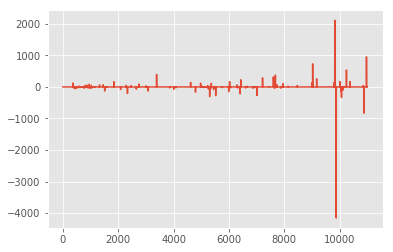

In [37]:
# 評価が大きく変わるタイミングを捉える
p1_df.diff()[1:].apery_eval[:11000].plot()

In [38]:
tmp = 0
diff_apery_eval = []

for diff in tqdm(diff_p1_df.apery_eval.tolist()):
    if (diff != 0) and (tmp != diff):
            tmp = diff
    diff_apery_eval.append(tmp)

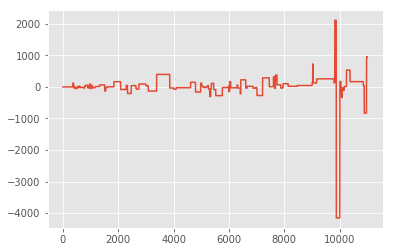

In [39]:
# インパルスなdiffをなめらかに
pd.Series(diff_apery_eval)[:11000].plot()

In [40]:
diff_p1_df["apery_eval"] = diff_apery_eval
diff_p2_df["apery_eval"] = diff_apery_eval

In [67]:
diff_p1_df.iloc[::300, 16:].head(10)

,LElbow_y,LElbow_z,REye_x,REye_y,REye_z,LEye_x,LEye_y,LEye_z,is_player,apery_eval
1,-0.10208,0.003835,-0.0608,-0.01103,-0.007519,0.0,0.0,0.0,0.0,0.0
301,-0.01990,0.001501,-1.8795,-1.81138,0.001824,0.0,0.0,0.0,0.0,0.0
601,-0.00016,-0.024444,-0.0229,-0.02508,0.004061,0.0,0.0,0.0,0.0,25.0
901,-1.85119,-0.016209,-0.0044,0.00226,0.000268,0.0,0.0,0.0,0.0,-25.0
1201,0.04587,0.014164,-0.0044,0.00192,0.001727,0.0,0.0,0.0,0.0,12.0
1501,1.86572,0.001833,0.0210,-1.83669,-0.007834,0.0,0.0,0.0,0.0,68.0
1801,0.03810,-0.003819,-0.0143,0.01776,0.003888,0.0,0.0,0.0,0.0,4.0
2101,-0.01083,0.001887,0.0005,0.00120,0.000194,0.0,0.0,0.0,0.0,-81.0
2401,-0.01239,0.004867,-0.0059,-0.00378,-0.002512,0.0,0.0,0.0,0.0,-208.0
2701,1.93759,-0.005423,-0.0024,-0.00258,-0.004119,0.0,0.0,0.0,0.0,-69.0


## 評価指標が500以上変化した局面を予測する

In [41]:
mask1 = (diff_p1_df.apery_eval[diff_p1_df.apery_eval > 500].index - 1).tolist()
mask2 = (diff_p2_df.apery_eval[diff_p2_df.apery_eval < -500].index - 1).tolist()

In [42]:
diff_p1_df.shape

(12445, 26)

In [43]:
variation_p1 = np.zeros(diff_p1_df.shape[0])
variation_p1[mask1] = 1

In [44]:
variation_p2 = np.zeros(diff_p2_df.shape[0])
variation_p2[mask2] = 1

In [45]:
variation_p1.shape

(12445,)

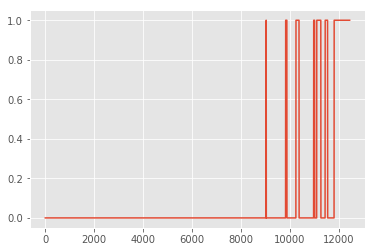

In [46]:
pd.Series(variation_p1).plot()

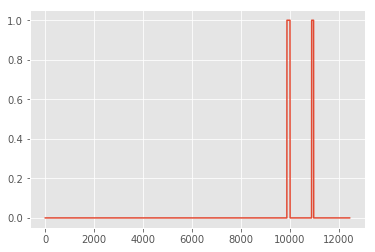

In [47]:
pd.Series(variation_p2).plot()

## 単純にRandomForestで予測してみる(パラメータチューニングなし)

0データが多すぎるのでsample関数で0の数を減らして再チャレンジ

In [56]:
X = diff_p1_df.iloc[:, :-2]
y = pd.Series(variation_p1)

In [57]:
y_prep = pd.concat([y[y == 0].sample(frac=0.1), y[y==1]])
X_prep = X.reset_index(drop=True).iloc[y_prep.sort_index().index.values]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.3, random_state=98, stratify=y_prep)

In [59]:
clf = RandomForestClassifier(random_state=98)

In [60]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=98, verbose=0, warm_start=False)

In [61]:
clf.feature_importances_

array([0.04737553, 0.04485988, 0.03772621, 0.04825852, 0.03913339,
       0.03436685, 0.0374231 , 0.04251627, 0.06100997, 0.04946909,
       0.04996772, 0.04503395, 0.06124889, 0.05525082, 0.03705992,
       0.049605  , 0.04074585, 0.03483566, 0.04219448, 0.04779913,
       0.04055017, 0.01980976, 0.01451928, 0.01924054])

In [62]:
accuracy_score(y_test, clf.predict(X_test))

0.6064610866372981

In [63]:
confusion_matrix(y_test, clf.predict(X_test))

array([[235, 104],
       [164, 178]])